In [984]:
import glob
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import product
import json
import matplotlib.pyplot as plt
import seaborn as sns

idx = pd.IndexSlice

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## LOAD RANDOM SEARCH DATA

### Load v3

In [985]:
rs_ver = "rs_v3"
base_path = f"data/ronin/{rs_ver}"

In [986]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop(['records', 'index'], axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['fps', 'highquality', 'rep', 'it', 'route_id'])
    return df

In [987]:

def make_df(path: str, shift_rep=0):

    # DATA FROM PATH
    data = {}
    data['path'] = path
    stem = Path(path).stem.split("_")
    data['fps'] = int(stem[1])
    data['highquality'] = stem[3]
    match path.split("/"):
        case ["data", "ronin", _, rep, "checkpoints", it, *objects]:
            data['rep'] = int(rep) + shift_rep
            data['it'] = int(it[2:])
    # print(data)

    # READ CHECKPOINT
    with open(path, "r") as f:
        content = json.load(f)

        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return

        df = pd.DataFrame(data)
        return process_df(df)


dfs = []
pattern = f"{base_path}/*/checkpoints/it*/*.json"
for file in glob.glob(pattern):
    dfs.append(make_df(file))

dfv3 = pd.concat(dfs).sort_index()[['driving_score', 'duration_system']]

dfv3.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1500 entries, (10, 'False', 0, 0, 'RouteScenario_556') to (20, 'True', 9, 24, 'RouteScenario_735')
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    1500 non-null   float64
 1   duration_system  1500 non-null   float64
dtypes: float64(2)
memory usage: 55.1+ KB


^ should be 1500 = 25 iter x 10 rep x 2 quality x 3 fps values

### Load v4
and shift repetition number +10

In [988]:
dfs = []
base_path = f"data/ronin/rs_v4"
pattern = f"{base_path}/*/checkpoints/it*/*.json"
for file in glob.glob(pattern):
    dfs.append(make_df(file, shift_rep=10))

dfv4 = pd.concat(dfs).sort_index()[['driving_score', 'duration_system']]
dfv4.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1645 entries, (10, 'False', 10, 0, 'RouteScenario_358') to (20, 'True', 24, 12, 'RouteScenario_74')
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    1645 non-null   float64
 1   duration_system  1645 non-null   float64
dtypes: float64(2)
memory usage: 58.6+ KB


In [989]:
dfs = []
for rep in [10, 11, 12, 13, 14, 20, 21, 22, 23, 24]:
    s = dfv4.xs(rep, level='rep', drop_level=False)
    dfs.append(s)


dfv4 = pd.concat(dfs, axis=0)
# dfv4.info()

### Concatonate v3 and v4

In [990]:
df = pd.concat([dfv3, dfv4]).sort_index()
# df = pd.concat([dfv3]).sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2977 entries, (10, 'False', 0, 0, 'RouteScenario_556') to (20, 'True', 24, 12, 'RouteScenario_74')
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    2977 non-null   float64
 1   duration_system  2977 non-null   float64
dtypes: float64(2)
memory usage: 87.9+ KB


## LOAD VERIFICATION DATA

In [991]:
def process_verification_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop(['records', 'index'], axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['route_id'])
    return df


def make_verification_df(path: str):

    # DATA FROM PATH
    data = {}
    data['path'] = path

    # READ CHECKPOINT
    with open(path, "r") as f:
        content = json.load(f)

        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return

        df = pd.DataFrame(data)
        return process_verification_df(df)

In [992]:
dfs = []
base_path = f"data/ronin/rs_v3"
pattern = f"{base_path}/verification/checkpoints/*/*.json"
for file in glob.glob(pattern):
    # print(file)
    dfs.append(make_verification_df(file))

oracle_df = pd.concat(dfs).sort_index()[['driving_score']]
oracle_df = oracle_df.rename(columns={"driving_score": "oracle_dscore"})
oracle_df

,oracle_dscore
route_id,
RouteScenario_0,0.65
RouteScenario_1,0.65
RouteScenario_10,1.00
RouteScenario_100,1.00
RouteScenario_101,0.70
...,...
RouteScenario_95,1.00
RouteScenario_96,1.00
RouteScenario_97,1.00


## JOIN VERIFICATION DATA

In [993]:
df

driving_score  duration_system
fps highquality rep it route_id                                         
10  False       0   0  RouteScenario_556       0.638565       514.576038
                    1  RouteScenario_461       0.096086       710.829181
                    2  RouteScenario_4         0.055417       512.520613
                    3  RouteScenario_578       1.000000       265.034359
                    4  RouteScenario_300       0.279849       624.154482
...                                                 ...              ...
20  True        24  8  RouteScenario_359       1.000000       363.694386
                    9  RouteScenario_65        0.650000       686.564993
                    10 RouteScenario_377       1.000000       219.122120
                    11 RouteScenario_509       0.116742      1270.492261
                    12 RouteScenario_74        1.000000       647.332757

[2977 rows x 2 columns]

In [994]:
# df = df.join(oracle_df).sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2977 entries, (10, 'False', 0, 0, 'RouteScenario_556') to (20, 'True', 24, 12, 'RouteScenario_74')
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    2977 non-null   float64
 1   duration_system  2977 non-null   float64
dtypes: float64(2)
memory usage: 87.9+ KB


## Cumulative MINIMUM

In [995]:


def get_solutions_of_iteration(curr_it):

    # get slice of data frame from iteration 0 to current iteration
    slice = df.loc[idx[:, :, :, :curr_it], :]

    solutions_idx = slice.groupby(['fps', 'highquality', 'rep',])[
        'driving_score'].idxmin().rename('solution_idx').to_frame()

    solutions_score = slice.groupby(['fps', 'highquality', 'rep',])[
        'driving_score'].min().rename('solution_score').to_frame()

    solutions = pd.concat([solutions_idx, solutions_score], axis=1)
    solutions['it'] = curr_it
    solutions = solutions.reset_index().set_index(
        ['fps', 'highquality', 'rep', 'it'])

    return solutions

In [996]:
# get_solutions_of_iteration(5)

In [997]:
NUM_OF_ITERAITON = 25

sols_df = pd.concat([get_solutions_of_iteration(it)
                    for it in range(NUM_OF_ITERAITON)], axis=0)

# at what iteration did we find the solution
sols_df['solution_it'] = sols_df['solution_idx'].apply(lambda x: x[-2])
# what is the route_id of the solution
sols_df['solution_route_id'] = sols_df['solution_idx'].apply(lambda x: x[-1])

# we don't need that once unpacked
sols_df = sols_df.drop('solution_idx', axis=1)

# add data from verification
sols_df = sols_df.join(oracle_df, on='solution_route_id')
sols_df = sols_df.sort_index()
sols_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3000 entries, (10, 'False', 0, 0) to (20, 'True', 24, 24)
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   solution_score     3000 non-null   float64
 1   solution_it        3000 non-null   int64  
 2   solution_route_id  3000 non-null   object 
 3   oracle_dscore      3000 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 107.4+ KB


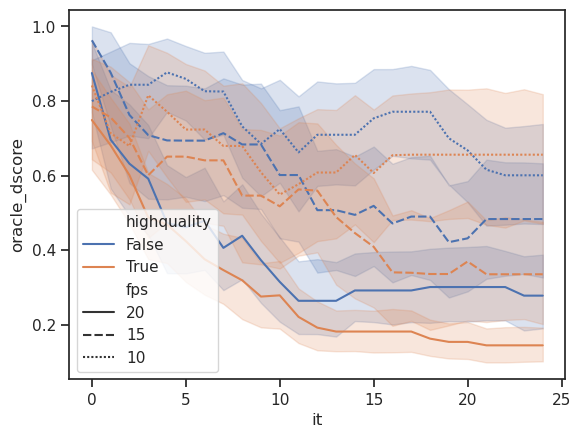

In [998]:
f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

ax = sns.lineplot(data=sols_df, x='it', y='oracle_dscore', style_order=[20, 15, 10],
                  style='fps', hue='highquality', ax=ax,)

In [999]:
cumulative_time = df.groupby(['fps', 'highquality', 'rep'])[
    'duration_system'].cumsum()
cumulative_time = cumulative_time.rename(
    'cumulative_time').to_frame().droplevel('route_id')

sols_df = sols_df.join(cumulative_time)

In [1000]:
sols_df

solution_score  solution_it  solution_route_id  oracle_dscore  cumulative_time
fps highquality rep it                                                                                
10  False       0   0         0.638565            0  RouteScenario_556        1.00000       514.576038
                    1         0.096086            1  RouteScenario_461        0.70000      1225.405219
                    2         0.055417            2    RouteScenario_4        1.00000      1737.925832
                    3         0.055417            2    RouteScenario_4        1.00000      2002.960191
                    4         0.055417            2    RouteScenario_4        1.00000      2627.114673
...                                ...          ...                ...            ...              ...
20  True        24  20        0.116742           11  RouteScenario_509        0.11069              NaN
                    21        0.116742           11  RouteScenario_509        0.11069              NaN
                    22        0.116742           11  RouteScenario_509        0.11069              NaN
                    23        0.116742           11  RouteScenario_509        0.11069              NaN
                    24        0.116742           11  RouteScenario_509        0.11069              NaN

[3000 rows x 5 columns]

In [1001]:
data = sols_df[['oracle_dscore', 'cumulative_time']
               ].groupby(['fps', 'highquality', 'it']).mean()

# data

In [1002]:
data.index = data.index.set_levels(data.index.levels[0].astype(str), level=0)
data = data.sort_index(ascending=False)
data.head()

oracle_dscore  cumulative_time
fps highquality it                                
20  True        24       0.144428     16934.831355
                23       0.144428     16382.572402
                22       0.144428     15754.019130
                21       0.144428     15109.189877
                20       0.153667     14363.857453

In [1003]:

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 150 entries, ('20', 'True', 24) to ('10', 'False', 0)
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   oracle_dscore    150 non-null    float64
 1   cumulative_time  150 non-null    float64
dtypes: float64(2)
memory usage: 3.3+ KB


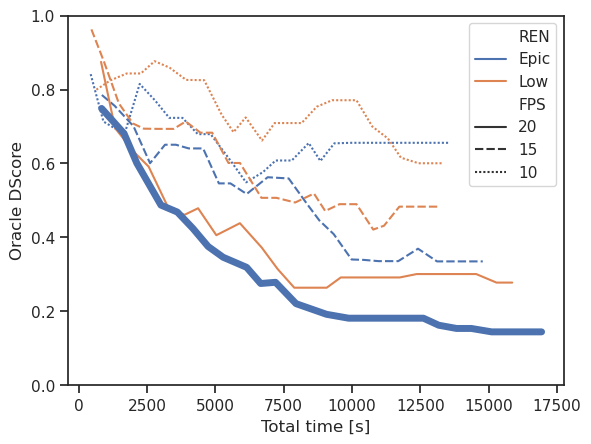

In [1004]:
sns.set_theme(style="ticks", palette="deep")

f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

sns.lineplot(data=data, x='cumulative_time', y='oracle_dscore',
             style='fps', hue='highquality', ax=ax, errorbar=None)

sns.lineplot(data=data.xs(("20", "True"), level=['fps', 'highquality'], drop_level=False),  x='cumulative_time',
             y='oracle_dscore', hue='highquality', ax=ax,  errorbar=None, lw=5)


ax.set_ylabel("Oracle DScore")
ax.set_xlabel("Total time [s]")
ax.set_ylim(0, 1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[
          'REN', 'Epic', 'Low', 'FPS', '20', '15', '10'])

## Statistical tests

In [1005]:
from scipy.stats import mannwhitneyu
from itertools import permutations

ITERATION = 0

In [1019]:


def do_test(fid_a, fid_b, set_a, set_b, confidence_level=0.99):
    U1, p = mannwhitneyu(set_a, set_b)

    max_error = 1 - confidence_level

    if p < max_error:
        print(
            f"\tAt {ITERATION = } the difference beetween {fid_a} and {fid_b} is statistically significant. {p = :.5f}")
        print(set_a)
        print(set_b)
    else:
        return
        print(
            f"\tAt {ITERATION = } the difference beetween {fid_a} and {fid_b} is not statistically significant. {p = :.5f}")

In [1020]:
#
oracle_dscores = sols_df.loc[idx[:, :, :, ITERATION]]['oracle_dscore'].groupby(
    ['fps', 'highquality',]).agg(list)

In [1021]:
# iterate over all possible fidelities
for (a_fid, a_list), (b_fid, b_list) in permutations(oracle_dscores.items(), 2):
    do_test(a_fid, b_fid, a_list, b_list)

	At ITERATION = 0 the difference beetween (10, 'False') and (15, 'False') is statistically significant. p = 0.00445
[1.0, 0.5147312360756197, 0.6, 0.65, 1.0, 0.8, 0.9399605080152691, 1.0, 1.0, 0.7, 1.0, 1.0, 0.8, 0.9418971882707559, 0.09316916577134964, 1.0, 0.11748559288326836, 0.8368075108371076, 1.0, 1.0]
[1.0, 1.0, 0.8, 0.45701156006483984, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
	At ITERATION = 0 the difference beetween (15, 'False') and (10, 'False') is statistically significant. p = 0.00445
[1.0, 1.0, 0.8, 0.45701156006483984, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 0.5147312360756197, 0.6, 0.65, 1.0, 0.8, 0.9399605080152691, 1.0, 1.0, 0.7, 1.0, 1.0, 0.8, 0.9418971882707559, 0.09316916577134964, 1.0, 0.11748559288326836, 0.8368075108371076, 1.0, 1.0]
	At ITERATION = 0 the difference beetween (15, 'False') and (20, 'True') is statistically significant. p = 0.00533
[1.0, 1.0, 0.8, 0.4570115600648